In [14]:
# pip install tensorflow numpy scikit-learn matplotlib

In [15]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import csv

In [16]:
train_dir = 'dataset_10/trainset'
test_dir = 'dataset_10/testset'

# Image dimensions
img_width, img_height = 224, 224

# Data Augmentation and Normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    validation_split=0.112 
)

# # Training data generator
# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(img_width, img_height),
#     batch_size=16,  
#     class_mode='binary',
#     subset='training'
# )

# # Validation data generator
# validation_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(img_width, img_height),
#     batch_size=16,  
#     class_mode='binary',
#     subset='validation'
# )

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 216 images belonging to 2 classes.


In [17]:
# Model Definitions
def create_custom_cnn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_width, img_height, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

def create_vgg16_model(fine_tune=False):
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    if fine_tune:
        for layer in base_model.layers[:-4]:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = False
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

def create_vgg19_model(fine_tune=False):
    base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    if fine_tune:
        for layer in base_model.layers[:-4]:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = False
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Visualization Function
def plot_training_history(history, model_name, batch_size, learning_rate):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy (Batch: {batch_size}, LR: {learning_rate})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f'{model_name} - Loss (Batch: {batch_size}, LR: {learning_rate})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()


def save_metrics_to_csv(file_name, metrics_list, fieldnames):
    
    with open(file_name, mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)

        if file.tell() == 0:
            writer.writeheader()

        for metrics in metrics_list:
            writer.writerow(metrics)


def evaluate_and_save(model_name, batch_size, lr, model, test_generator, csv_file):
    # Evaluate model on test data
    test_generator.reset()  
    predictions = model.predict(test_generator, steps=test_generator.samples)
    y_pred = np.where(predictions.ravel() > 0.5, 1, 0)
    y_true = test_generator.classes

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)

    
    metrics = {
        'Model Name': model_name,
        'Batch Size': batch_size,
        'Learning Rate': lr,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    fieldnames = ['Model Name', 'Batch Size', 'Learning Rate', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
    
    save_metrics_to_csv(csv_file, [metrics], fieldnames)

    # Print metrics
    print(f"Model: {model_name}, Batch: {batch_size}, LR: {lr}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [18]:
model_configs = [
    {'name': 'Custom_CNN', 'create_model': create_custom_cnn},
    {'name': 'VGG16', 'create_model': create_vgg16_model, 'fine_tune': False},
    {'name': 'VGG19', 'create_model': create_vgg19_model, 'fine_tune': False},
    {'name': 'FineTuned_VGG16', 'create_model': create_vgg16_model, 'fine_tune': True},
    {'name': 'FineTuned_VGG19', 'create_model': create_vgg19_model, 'fine_tune': True},
]

# Hyperparameters
batch_sizes = [16, 32]
learning_rates = [0.0001, 0.00001]
epochs = 10


Training Custom_CNN with batch size 16 and learning rate 0.0001
Found 1716 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 175ms/step - accuracy: 0.6107 - loss: 0.6672 - val_accuracy: 0.6898 - val_loss: 0.5819
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 0.6600 - loss: 0.6119 - val_accuracy: 0.6759 - val_loss: 0.6035
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 0.6652 - loss: 0.5865 - val_accuracy: 0.7361 - val_loss: 0.5475
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.6766 - loss: 0.5745 - val_accuracy: 0.7222 - val_loss: 0.5477
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.6969 - loss: 0.5782 - val_accuracy: 0.7083 - val_loss: 0.5789
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.7052 - loss: 0.5633 - val_accuracy: 0.7176 - val_loss: 0.5370
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy:

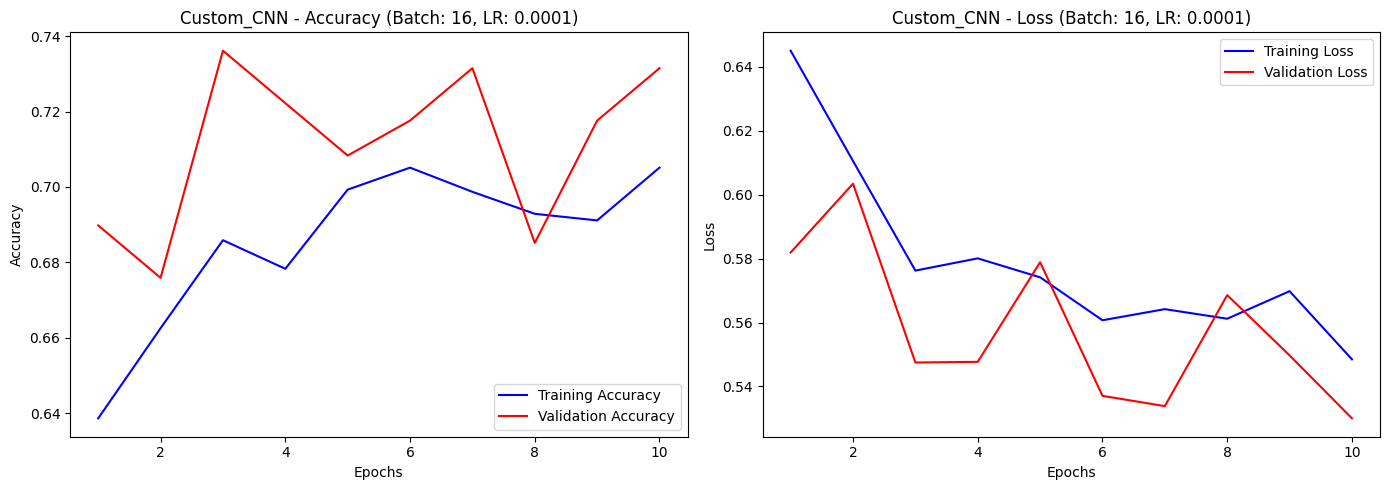

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model: Custom_CNN, Batch: 16, LR: 0.0001
Confusion Matrix:
[[107  17]
 [  6  86]]
Accuracy: 0.8935
Precision: 0.8350
Recall: 0.9348
F1 Score: 0.8821

Training Custom_CNN with batch size 16 and learning rate 1e-05
Found 1716 images belonging to 2 classes.
Found 216 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 175ms/step - accuracy: 0.6245 - loss: 0.6628 - val_accuracy: 0.6620 - val_loss: 0.6113
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.6789 - loss: 0.6105 - val_accuracy: 0.6898 - val_loss: 0.5948
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.6805 - loss: 0.5970 - val_accuracy: 0.6852 - val_loss: 0.5793
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 0.7027 - loss: 0.5718 - val_accuracy: 0.6574 - val_loss: 0.5899
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.6616 - loss: 0.5951 - val_accuracy: 0.7315 - val_loss: 0.5680
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 0.6940 - loss: 0.5811 - val_accuracy: 0.7361 - val_loss: 0.5430
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.6835 - loss: 0.5759 - val_accuracy: 0.7176 - val_loss: 0.5176
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 0.6944 - loss: 0.5869 - val

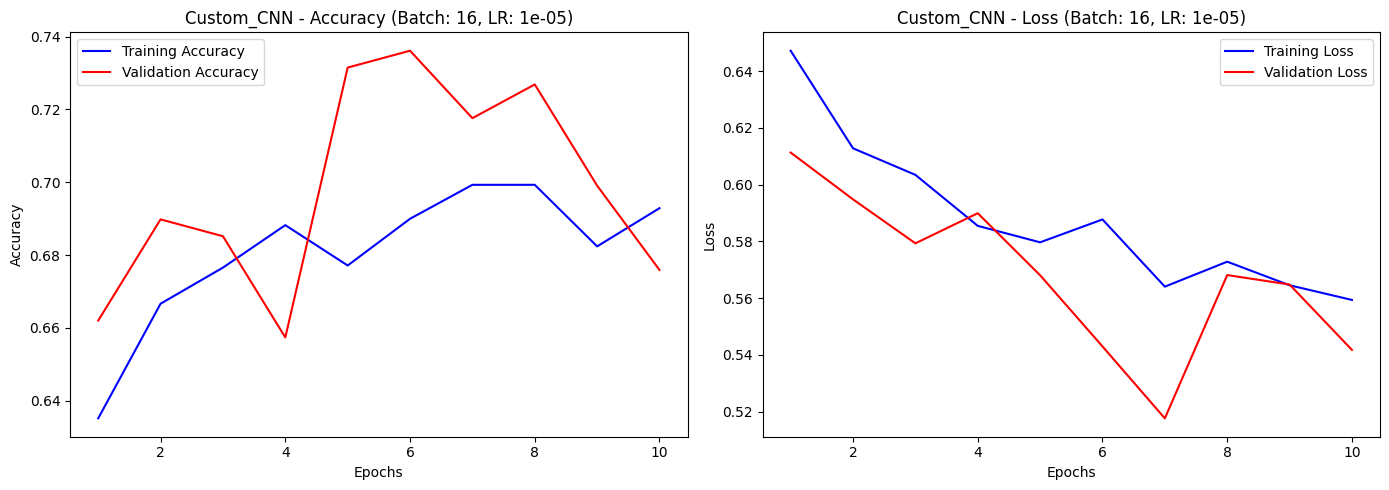

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model: Custom_CNN, Batch: 16, LR: 1e-05
Confusion Matrix:
[[112  12]
 [ 15  77]]
Accuracy: 0.8750
Precision: 0.8652
Recall: 0.8370
F1 Score: 0.8508

Training Custom_CNN with batch size 32 and learning rate 0.0001
Found 1716 images belonging to 2 classes.
Found 216 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 327ms/step - accuracy: 0.5953 - loss: 0.6707 - val_accuracy: 0.6944 - val_loss: 0.5825
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 291ms/step - accuracy: 0.6865 - loss: 0.5995 - val_accuracy: 0.6944 - val_loss: 0.5847
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 296ms/step - accuracy: 0.6774 - loss: 0.5950 - val_accuracy: 0.6481 - val_loss: 0.6024
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - accuracy: 0.6851 - loss: 0.6001 - val_accuracy: 0.6852 - val_loss: 0.5892
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - accuracy: 0.6951 - loss: 0.5638 - val_accuracy: 0.6898 - val_loss: 0.5806
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 295ms/step - accuracy: 0.6573 - loss: 0.5838 - val_accuracy: 0.7130 - val_loss: 0.5651
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - accuracy: 0.7096 - loss: 0.5394 - val_accuracy: 0.6713 - val_loss: 0.5627
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 291ms/step - accuracy: 0.6952 - loss: 0.5670 - val_accuracy: 0.662

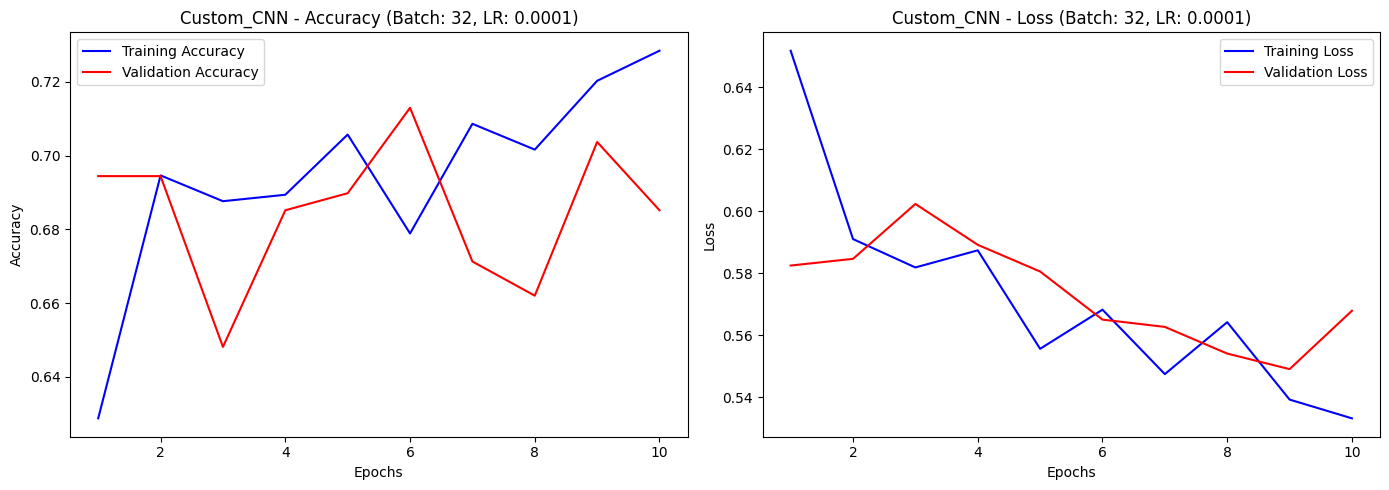

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model: Custom_CNN, Batch: 32, LR: 0.0001
Confusion Matrix:
[[110  14]
 [  6  86]]
Accuracy: 0.9074
Precision: 0.8600
Recall: 0.9348
F1 Score: 0.8958

Training Custom_CNN with batch size 32 and learning rate 1e-05
Found 1716 images belonging to 2 classes.
Found 216 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 330ms/step - accuracy: 0.5967 - loss: 0.6738 - val_accuracy: 0.6111 - val_loss: 0.6380
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 291ms/step - accuracy: 0.6658 - loss: 0.6180 - val_accuracy: 0.6944 - val_loss: 0.6064
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - accuracy: 0.6885 - loss: 0.5924 - val_accuracy: 0.6898 - val_loss: 0.5737
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 292ms/step - accuracy: 0.6640 - loss: 0.6031 - val_accuracy: 0.7037 - val_loss: 0.5810
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 298ms/step - accuracy: 0.6916 - loss: 0.5712 - val_accuracy: 0.7176 - val_loss: 0.5367
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 294ms/step - accuracy: 0.6577 - loss: 0.6032 - val_accuracy: 0.7361 - val_loss: 0.5261
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 294ms/step - accuracy: 0.7042 - loss: 0.5650 - val_accuracy: 0.6620 - val_loss: 0.6097
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 295ms/step - accuracy: 0.6850 - loss: 0.5672 - val_accuracy: 0.699

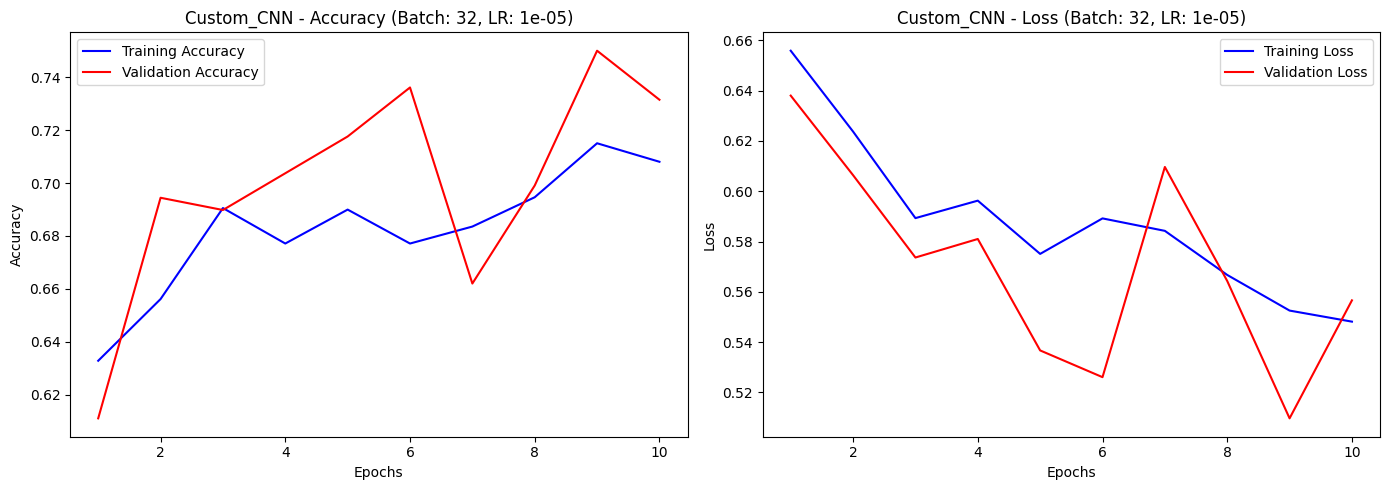

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model: Custom_CNN, Batch: 32, LR: 1e-05
Confusion Matrix:
[[111  13]
 [ 15  77]]
Accuracy: 0.8704
Precision: 0.8556
Recall: 0.8370
F1 Score: 0.8462

Training VGG16 with batch size 16 and learning rate 0.0001
Found 1716 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - accuracy: 0.6219 - loss: 0.6871 - val_accuracy: 0.7917 - val_loss: 0.4705
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.7293 - loss: 0.5270 - val_accuracy: 0.8194 - val_loss: 0.4164
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.7680 - loss: 0.4948 - val_accuracy: 0.8009 - val_loss: 0.4528
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.7890 - loss: 0.4534 - val_accuracy: 0.8333 - val_loss: 0.4226
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.7906 - loss: 0.4413 - val_accuracy: 0.7824 - val_loss: 0.4502
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.8136 - loss: 0.4312 - val_accuracy: 0.7454 - val_loss: 0.4885
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.8050 - loss: 0.4176 - val_accuracy: 0.8102 - val_loss: 0.4050
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.8255 - loss: 0.4050 - val

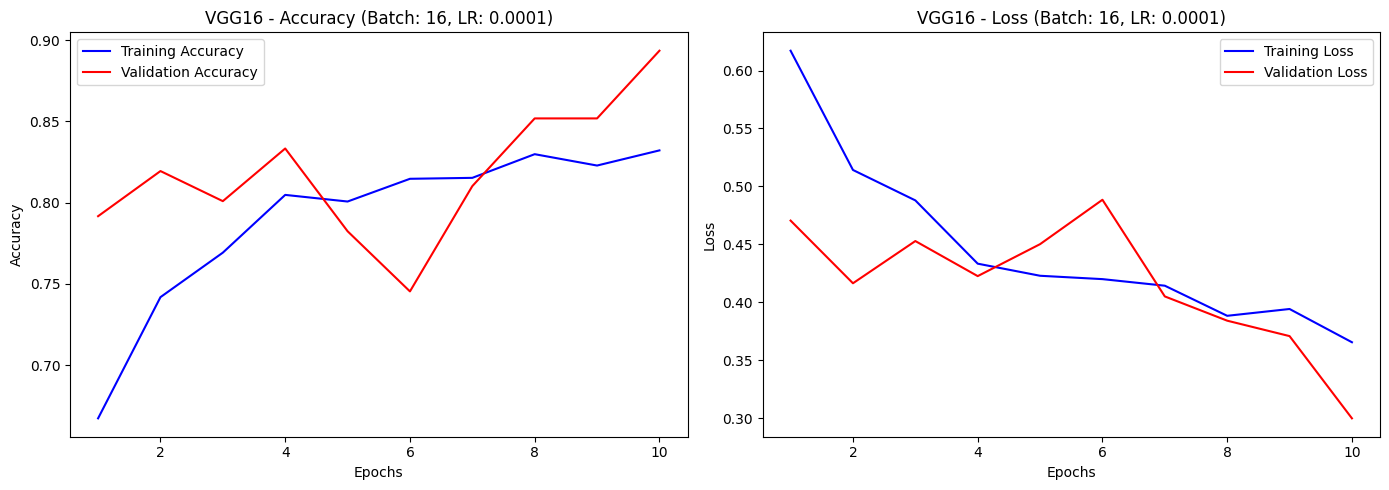

216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Model: VGG16, Batch: 16, LR: 0.0001
Confusion Matrix:
[[119   5]
 [  7  85]]
Accuracy: 0.9444
Precision: 0.9444
Recall: 0.9239
F1 Score: 0.9341

Training VGG16 with batch size 16 and learning rate 1e-05
Found 1716 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 22s 175ms/step - accuracy: 0.5290 - loss: 0.7470 - val_accuracy: 0.7130 - val_loss: 0.5691
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.6755 - loss: 0.5926 - val_accuracy: 0.7685 - val_loss: 0.5193
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.7349 - loss: 0.5414 - val_accuracy: 0.7639 - val_loss: 0.5071
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.7472 - loss: 0.5226 - val_accuracy: 0.8009 - val_loss: 0.4662
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.7823 - loss: 0.4853 - val_accuracy: 0.7870 - val_loss: 0.4635
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.7810 - loss: 0.4632 - val_accuracy: 0.7778 - val_loss: 0.4560
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.7701 - loss: 0.4643 - val_accuracy: 0.8194 - val_loss: 0.4434
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.7973 - loss: 0.4527 - val

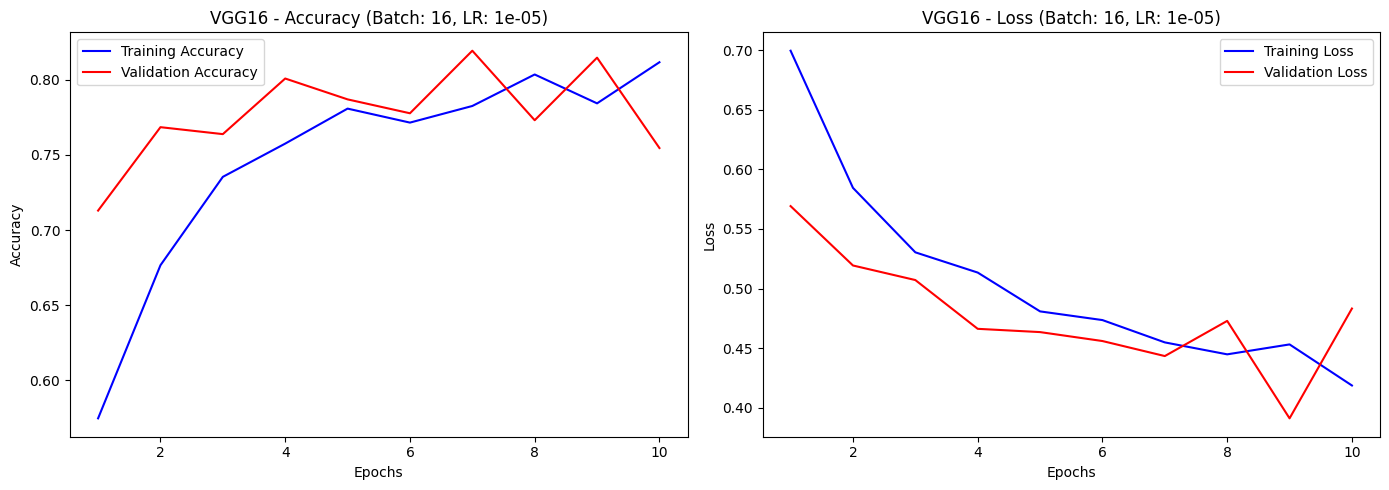

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model: VGG16, Batch: 16, LR: 1e-05
Confusion Matrix:
[[112  12]
 [  6  86]]
Accuracy: 0.9167
Precision: 0.8776
Recall: 0.9348
F1 Score: 0.9053

Training VGG16 with batch size 32 and learning rate 0.0001
Found 1716 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 505ms/step - accuracy: 0.5894 - loss: 0.6965 - val_accuracy: 0.7917 - val_loss: 0.4960
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 300ms/step - accuracy: 0.7507 - loss: 0.5318 - val_accuracy: 0.7500 - val_loss: 0.5122
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 295ms/step - accuracy: 0.7937 - loss: 0.4485 - val_accuracy: 0.8380 - val_loss: 0.3992
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 296ms/step - accuracy: 0.7787 - loss: 0.4459 - val_accuracy: 0.8056 - val_loss: 0.3947
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 294ms/step - accuracy: 0.7982 - loss: 0.4284 - val_accuracy: 0.8287 - val_loss: 0.3937
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 295ms/step - accuracy: 0.8129 - loss: 0.4108 - val_accuracy: 0.8426 - val_loss: 0.3553
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 295ms/step - accuracy: 0.8014 - loss: 0.4290 - val_accuracy: 0.8565 - val_loss: 0.3412
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 296ms/step - accuracy: 0.8428 - loss: 0.3652 - val_accuracy: 0.847

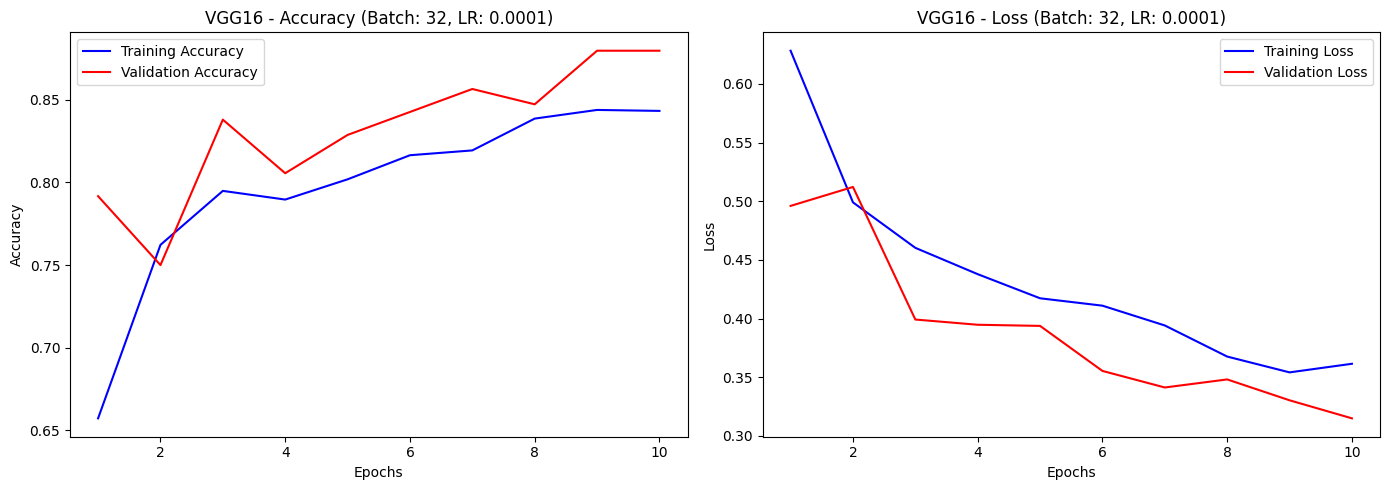

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model: VGG16, Batch: 32, LR: 0.0001
Confusion Matrix:
[[117   7]
 [  3  89]]
Accuracy: 0.9537
Precision: 0.9271
Recall: 0.9674
F1 Score: 0.9468

Training VGG16 with batch size 32 and learning rate 1e-05
Found 1716 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 326ms/step - accuracy: 0.5618 - loss: 0.7160 - val_accuracy: 0.6806 - val_loss: 0.5883
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 297ms/step - accuracy: 0.6686 - loss: 0.6117 - val_accuracy: 0.7176 - val_loss: 0.5620
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 296ms/step - accuracy: 0.7134 - loss: 0.5693 - val_accuracy: 0.7361 - val_loss: 0.5211
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 295ms/step - accuracy: 0.7392 - loss: 0.5219 - val_accuracy: 0.7407 - val_loss: 0.5056
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 294ms/step - accuracy: 0.7439 - loss: 0.5179 - val_accuracy: 0.7778 - val_loss: 0.4773
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 298ms/step - accuracy: 0.7593 - loss: 0.5091 - val_accuracy: 0.7593 - val_loss: 0.4899
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 297ms/step - accuracy: 0.7674 - loss: 0.4882 - val_accuracy: 0.7917 - val_loss: 0.4459
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 297ms/step - accuracy: 0.7713 - loss: 0.4792 - val_accuracy: 0.763

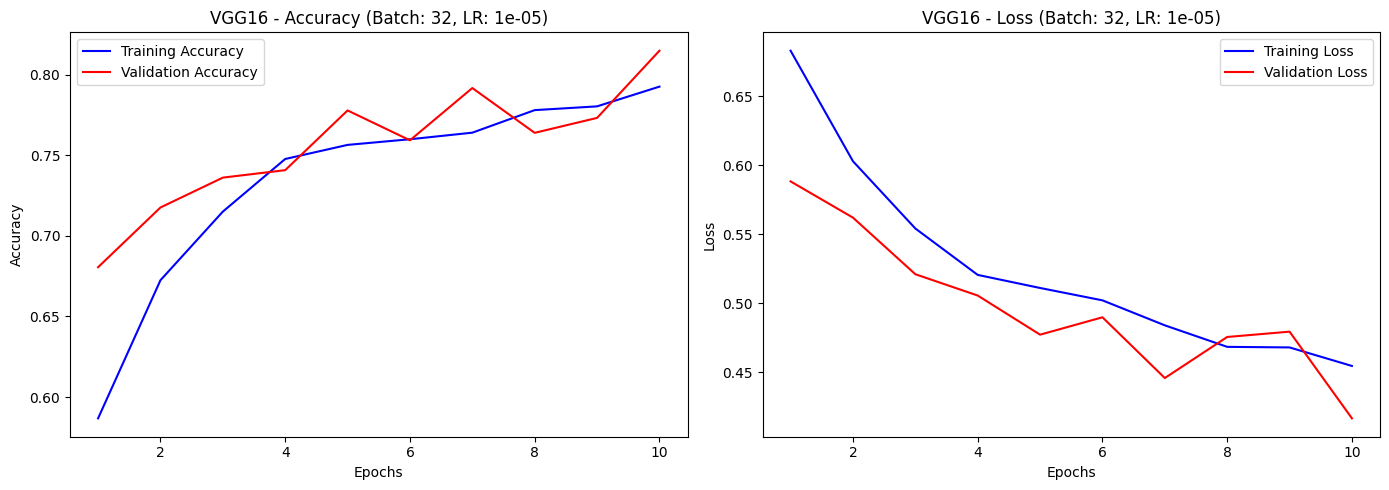

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model: VGG16, Batch: 32, LR: 1e-05
Confusion Matrix:
[[113  11]
 [ 11  81]]
Accuracy: 0.8981
Precision: 0.8804
Recall: 0.8804
F1 Score: 0.8804

Training VGG19 with batch size 16 and learning rate 0.0001
Found 1716 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.5738 - loss: 0.8193 - val_accuracy: 0.7176 - val_loss: 0.5543
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.7304 - loss: 0.5322 - val_accuracy: 0.7639 - val_loss: 0.5352
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.7687 - loss: 0.5076 - val_accuracy: 0.7639 - val_loss: 0.5074
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.7527 - loss: 0.4906 - val_accuracy: 0.6944 - val_loss: 0.5657
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.7666 - loss: 0.4793 - val_accuracy: 0.8148 - val_loss: 0.4181
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.7728 - loss: 0.4711 - val_accuracy: 0.7731 - val_loss: 0.4787
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.7782 - loss: 0.4580 - val_accuracy: 0.7593 - val_loss: 0.4976
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.7754 - loss: 0.4727 - val

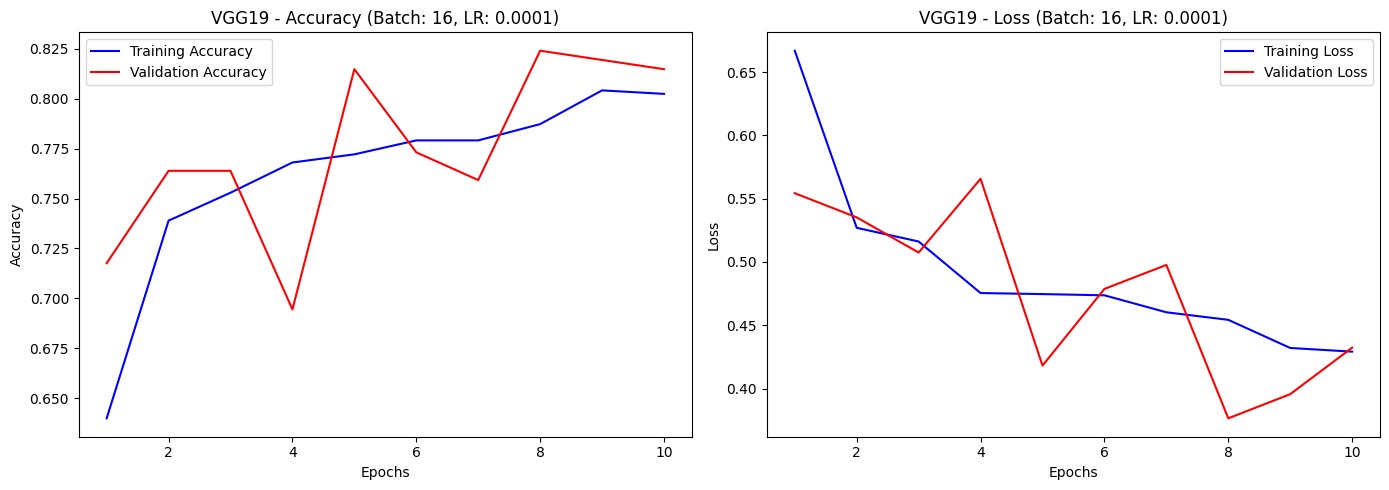

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Model: VGG19, Batch: 16, LR: 0.0001
Confusion Matrix:
[[114  10]
 [  7  85]]
Accuracy: 0.9213
Precision: 0.8947
Recall: 0.9239
F1 Score: 0.9091

Training VGG19 with batch size 16 and learning rate 1e-05
Found 1716 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 22s 176ms/step - accuracy: 0.5673 - loss: 0.7142 - val_accuracy: 0.7130 - val_loss: 0.5710
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.6775 - loss: 0.5958 - val_accuracy: 0.7778 - val_loss: 0.5367
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.7368 - loss: 0.5270 - val_accuracy: 0.7639 - val_loss: 0.5366
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.7186 - loss: 0.5456 - val_accuracy: 0.7315 - val_loss: 0.5200
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.7492 - loss: 0.5108 - val_accuracy: 0.7731 - val_loss: 0.4948
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.7658 - loss: 0.4909 - val_accuracy: 0.7685 - val_loss: 0.4738
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.7611 - loss: 0.4817 - val_accuracy: 0.7870 - val_loss: 0.4542
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.7667 - loss: 0.4731 - val

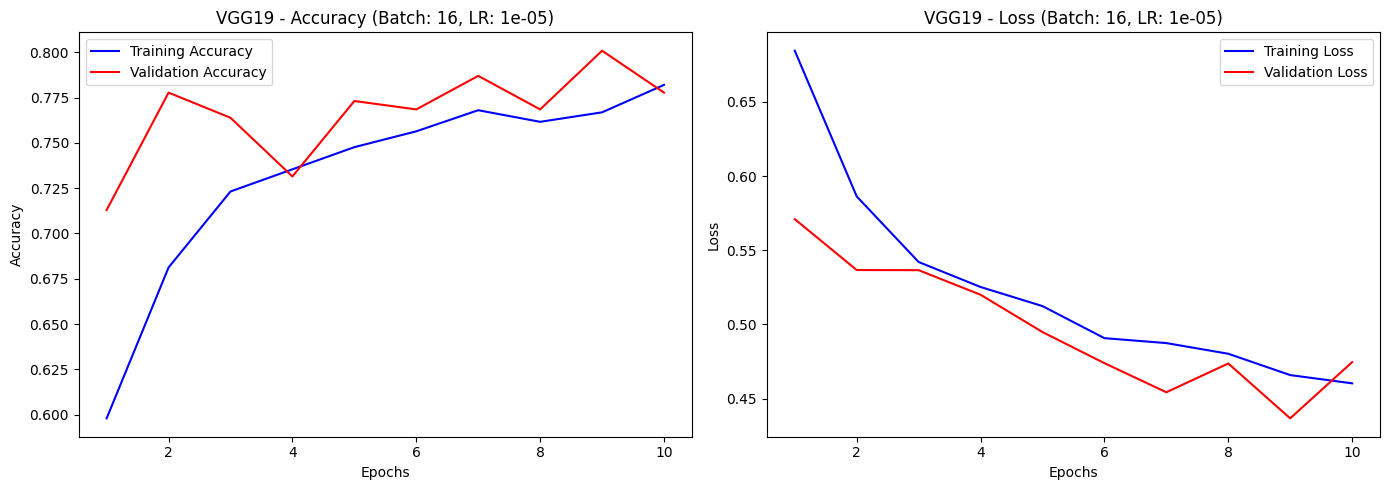

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Model: VGG19, Batch: 16, LR: 1e-05
Confusion Matrix:
[[115   9]
 [ 16  76]]
Accuracy: 0.8843
Precision: 0.8941
Recall: 0.8261
F1 Score: 0.8588

Training VGG19 with batch size 32 and learning rate 0.0001
Found 1716 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 329ms/step - accuracy: 0.6200 - loss: 0.7051 - val_accuracy: 0.7500 - val_loss: 0.5252
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 298ms/step - accuracy: 0.7124 - loss: 0.5507 - val_accuracy: 0.7315 - val_loss: 0.5071
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 297ms/step - accuracy: 0.7372 - loss: 0.5074 - val_accuracy: 0.7130 - val_loss: 0.5325
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 298ms/step - accuracy: 0.7712 - loss: 0.4850 - val_accuracy: 0.7917 - val_loss: 0.4581
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 299ms/step - accuracy: 0.7777 - loss: 0.4618 - val_accuracy: 0.7639 - val_loss: 0.4486
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 299ms/step - accuracy: 0.7921 - loss: 0.4543 - val_accuracy: 0.8056 - val_loss: 0.3940
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 296ms/step - accuracy: 0.8068 - loss: 0.4245 - val_accuracy: 0.8102 - val_loss: 0.4075
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 297ms/step - accuracy: 0.7857 - loss: 0.4535 - val_accuracy: 0.810

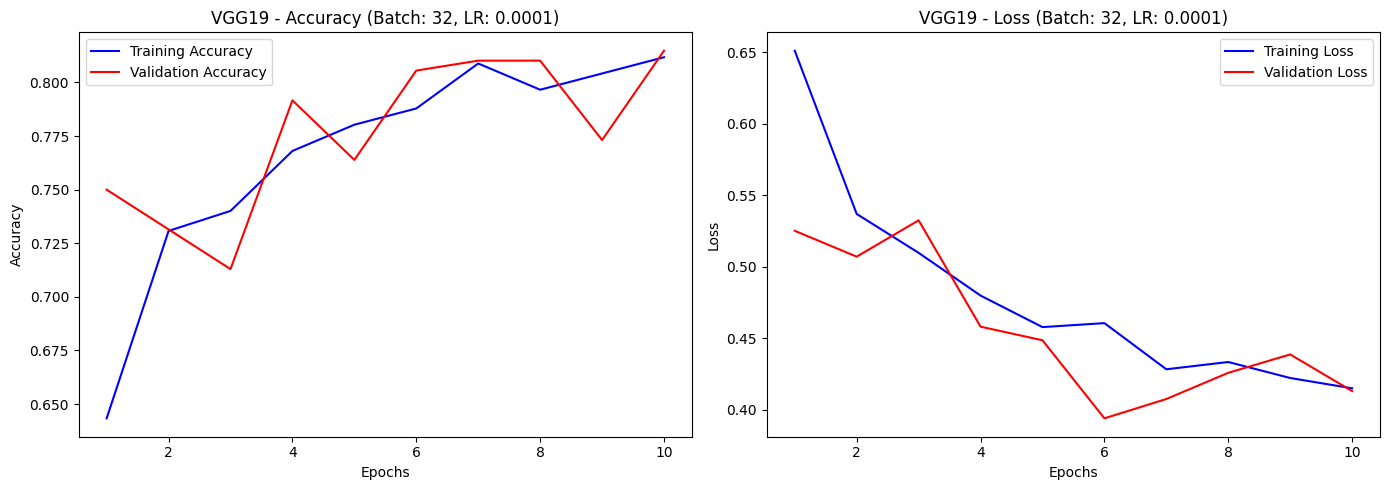

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Model: VGG19, Batch: 32, LR: 0.0001
Confusion Matrix:
[[120   4]
 [ 17  75]]
Accuracy: 0.9028
Precision: 0.9494
Recall: 0.8152
F1 Score: 0.8772

Training VGG19 with batch size 32 and learning rate 1e-05
Found 1716 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 325ms/step - accuracy: 0.5125 - loss: 0.7839 - val_accuracy: 0.6991 - val_loss: 0.6057
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 297ms/step - accuracy: 0.6223 - loss: 0.6531 - val_accuracy: 0.7176 - val_loss: 0.5815
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 300ms/step - accuracy: 0.6773 - loss: 0.5981 - val_accuracy: 0.7454 - val_loss: 0.5503
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 303ms/step - accuracy: 0.7226 - loss: 0.5607 - val_accuracy: 0.7639 - val_loss: 0.5043
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 298ms/step - accuracy: 0.7196 - loss: 0.5408 - val_accuracy: 0.7546 - val_loss: 0.4945
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 297ms/step - accuracy: 0.7451 - loss: 0.5089 - val_accuracy: 0.7870 - val_loss: 0.4863
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 300ms/step - accuracy: 0.7420 - loss: 0.5186 - val_accuracy: 0.7917 - val_loss: 0.4863
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 296ms/step - accuracy: 0.7542 - loss: 0.4974 - val_accuracy: 0.791

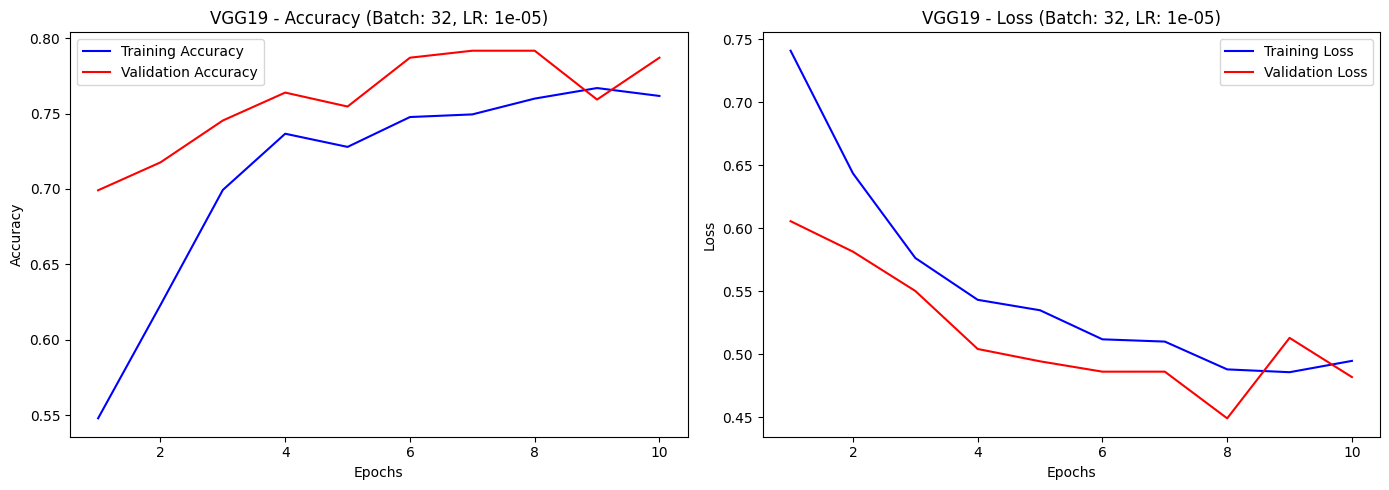

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Model: VGG19, Batch: 32, LR: 1e-05
Confusion Matrix:
[[117   7]
 [ 12  80]]
Accuracy: 0.9120
Precision: 0.9195
Recall: 0.8696
F1 Score: 0.8939

Training FineTuned_VGG16 with batch size 16 and learning rate 0.0001
Found 1716 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 183ms/step - accuracy: 0.6532 - loss: 0.6315 - val_accuracy: 0.8750 - val_loss: 0.3667
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.8385 - loss: 0.3879 - val_accuracy: 0.9259 - val_loss: 0.2264
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.9176 - loss: 0.2316 - val_accuracy: 0.8102 - val_loss: 0.3988
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.8853 - loss: 0.2757 - val_accuracy: 0.9583 - val_loss: 0.1421
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.9247 - loss: 0.1832 - val_accuracy: 0.9583 - val_loss: 0.1049
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.9279 - loss: 0.1733 - val_accuracy: 0.9398 - val_loss: 0.1455
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.9382 - loss: 0.1549 - val_accuracy: 0.9722 - val_loss: 0.1011
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.9459 - loss: 0.1588 - val

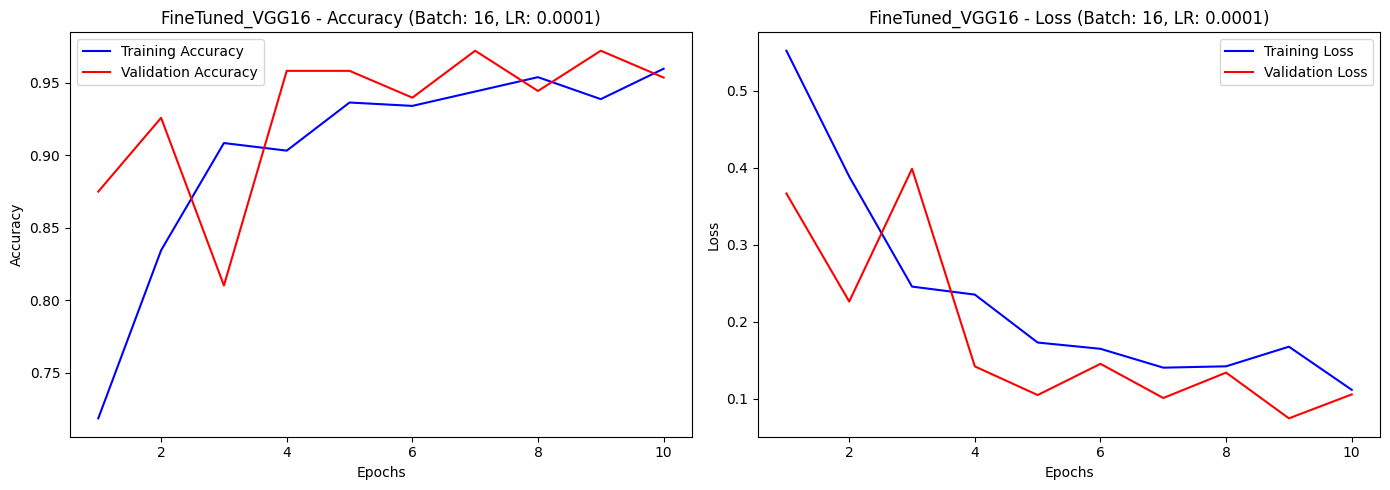

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model: FineTuned_VGG16, Batch: 16, LR: 0.0001
Confusion Matrix:
[[124   0]
 [  9  83]]
Accuracy: 0.9583
Precision: 1.0000
Recall: 0.9022
F1 Score: 0.9486

Training FineTuned_VGG16 with batch size 16 and learning rate 1e-05
Found 1716 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 180ms/step - accuracy: 0.5772 - loss: 0.7033 - val_accuracy: 0.7639 - val_loss: 0.5071
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 19s 161ms/step - accuracy: 0.7458 - loss: 0.5102 - val_accuracy: 0.7824 - val_loss: 0.4483
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.8040 - loss: 0.4269 - val_accuracy: 0.8843 - val_loss: 0.3307
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.8570 - loss: 0.3381 - val_accuracy: 0.9074 - val_loss: 0.2511
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.8824 - loss: 0.2878 - val_accuracy: 0.9213 - val_loss: 0.2020
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.8894 - loss: 0.2649 - val_accuracy: 0.8657 - val_loss: 0.3126
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.9137 - loss: 0.2375 - val_accuracy: 0.8889 - val_loss: 0.2356
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.9326 - loss: 0.1655 - val

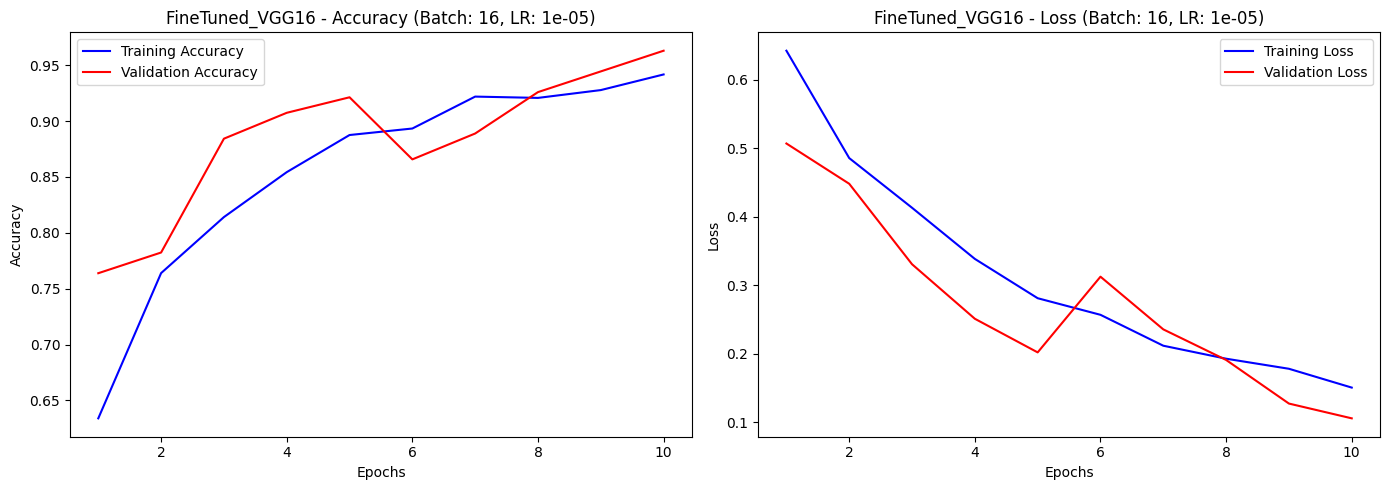

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model: FineTuned_VGG16, Batch: 16, LR: 1e-05
Confusion Matrix:
[[124   0]
 [  5  87]]
Accuracy: 0.9769
Precision: 1.0000
Recall: 0.9457
F1 Score: 0.9721

Training FineTuned_VGG16 with batch size 32 and learning rate 0.0001
Found 1716 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 340ms/step - accuracy: 0.6350 - loss: 0.6746 - val_accuracy: 0.7593 - val_loss: 0.4604
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 296ms/step - accuracy: 0.8389 - loss: 0.3845 - val_accuracy: 0.9259 - val_loss: 0.2339
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 297ms/step - accuracy: 0.8611 - loss: 0.3214 - val_accuracy: 0.9259 - val_loss: 0.1740
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 300ms/step - accuracy: 0.9120 - loss: 0.2143 - val_accuracy: 0.9074 - val_loss: 0.1857
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 296ms/step - accuracy: 0.9199 - loss: 0.2117 - val_accuracy: 0.9722 - val_loss: 0.0881
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 298ms/step - accuracy: 0.9441 - loss: 0.1496 - val_accuracy: 0.9630 - val_loss: 0.1087
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 299ms/step - accuracy: 0.9419 - loss: 0.1407 - val_accuracy: 0.9583 - val_loss: 0.0946
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 296ms/step - accuracy: 0.9635 - loss: 0.0970 - val_accuracy: 0.967

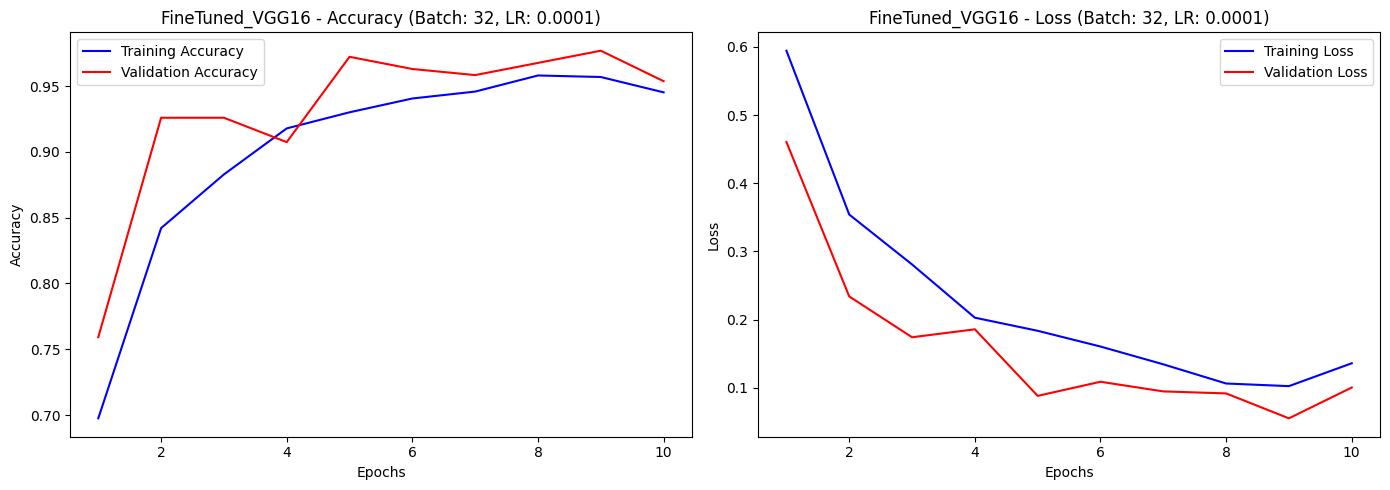

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model: FineTuned_VGG16, Batch: 32, LR: 0.0001
Confusion Matrix:
[[123   1]
 [  7  85]]
Accuracy: 0.9630
Precision: 0.9884
Recall: 0.9239
F1 Score: 0.9551

Training FineTuned_VGG16 with batch size 32 and learning rate 1e-05
Found 1716 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 327ms/step - accuracy: 0.6059 - loss: 0.6858 - val_accuracy: 0.7731 - val_loss: 0.5414
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 298ms/step - accuracy: 0.7135 - loss: 0.5499 - val_accuracy: 0.7315 - val_loss: 0.5046
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 298ms/step - accuracy: 0.7735 - loss: 0.4620 - val_accuracy: 0.8102 - val_loss: 0.4244
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 296ms/step - accuracy: 0.8168 - loss: 0.4010 - val_accuracy: 0.8657 - val_loss: 0.3255
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 299ms/step - accuracy: 0.8597 - loss: 0.3399 - val_accuracy: 0.8796 - val_loss: 0.2807
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 300ms/step - accuracy: 0.8901 - loss: 0.2808 - val_accuracy: 0.9167 - val_loss: 0.2326
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 302ms/step - accuracy: 0.8922 - loss: 0.2605 - val_accuracy: 0.8981 - val_loss: 0.2255
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 295ms/step - accuracy: 0.9154 - loss: 0.2264 - val_accuracy: 0.967

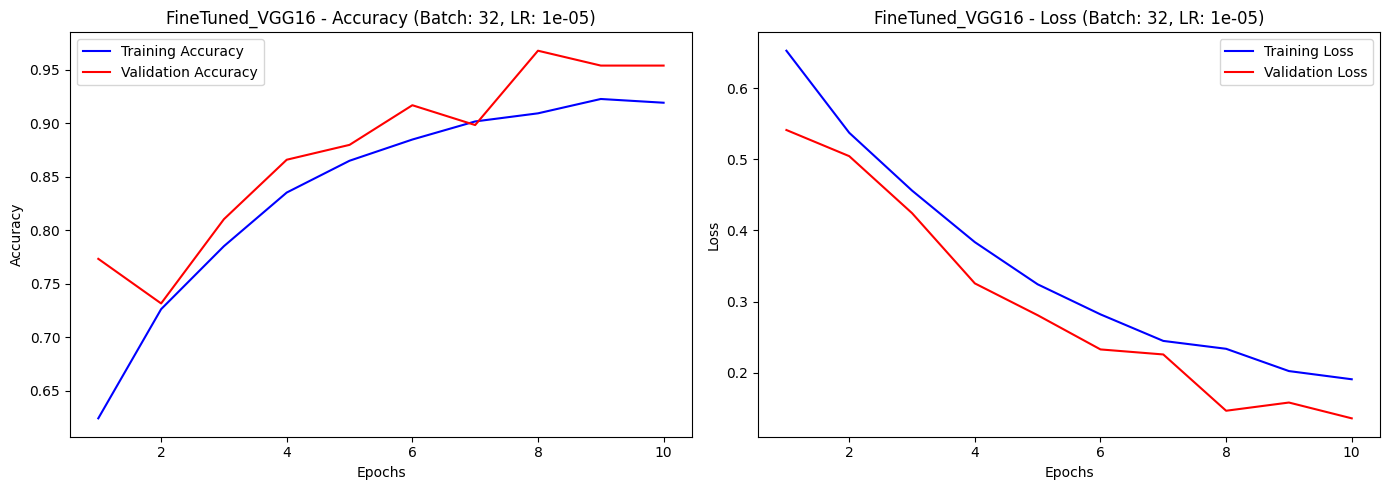

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model: FineTuned_VGG16, Batch: 32, LR: 1e-05
Confusion Matrix:
[[123   1]
 [  3  89]]
Accuracy: 0.9815
Precision: 0.9889
Recall: 0.9674
F1 Score: 0.9780

Training FineTuned_VGG19 with batch size 16 and learning rate 0.0001
Found 1716 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 182ms/step - accuracy: 0.6458 - loss: 0.6563 - val_accuracy: 0.8472 - val_loss: 0.3706
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.7903 - loss: 0.4355 - val_accuracy: 0.8241 - val_loss: 0.3796
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.8600 - loss: 0.3271 - val_accuracy: 0.8194 - val_loss: 0.3990
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.8994 - loss: 0.2521 - val_accuracy: 0.9352 - val_loss: 0.1708
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.8655 - loss: 0.3134 - val_accuracy: 0.8380 - val_loss: 0.4510
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.9029 - loss: 0.2821 - val_accuracy: 0.9352 - val_loss: 0.1416
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.9054 - loss: 0.2325 - val_accuracy: 0.9120 - val_loss: 0.2215
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.9278 - loss: 0.1730 - val

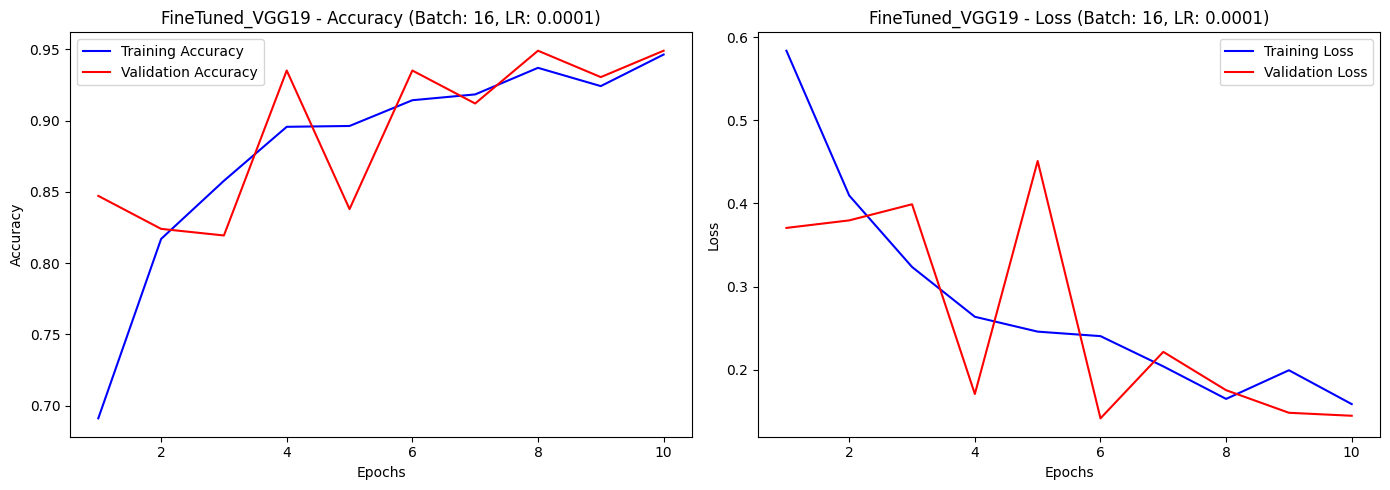

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Model: FineTuned_VGG19, Batch: 16, LR: 0.0001
Confusion Matrix:
[[124   0]
 [ 11  81]]
Accuracy: 0.9491
Precision: 1.0000
Recall: 0.8804
F1 Score: 0.9364

Training FineTuned_VGG19 with batch size 16 and learning rate 1e-05
Found 1716 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/step - accuracy: 0.5782 - loss: 0.7038 - val_accuracy: 0.7639 - val_loss: 0.5100
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.7061 - loss: 0.5363 - val_accuracy: 0.7963 - val_loss: 0.4649
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.7909 - loss: 0.4538 - val_accuracy: 0.8009 - val_loss: 0.4239
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 162ms/step - accuracy: 0.8130 - loss: 0.4002 - val_accuracy: 0.8889 - val_loss: 0.3095
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.8610 - loss: 0.3360 - val_accuracy: 0.8704 - val_loss: 0.3101
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.8732 - loss: 0.2998 - val_accuracy: 0.9120 - val_loss: 0.2116
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.9143 - loss: 0.2295 - val_accuracy: 0.8981 - val_loss: 0.2400
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.8863 - loss: 0.2482 - val

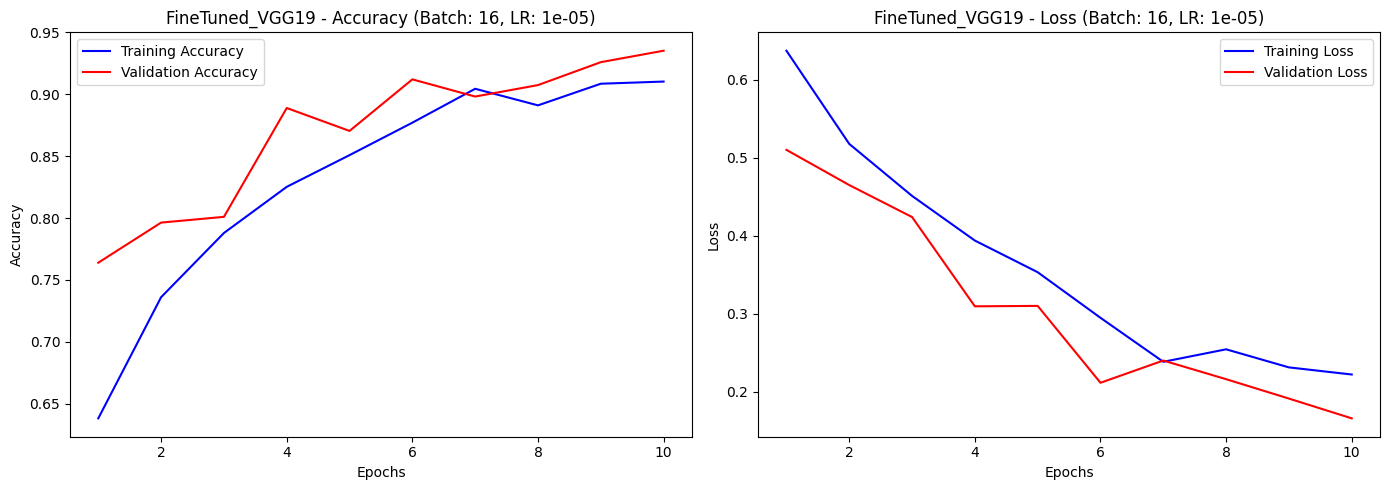

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Model: FineTuned_VGG19, Batch: 16, LR: 1e-05
Confusion Matrix:
[[120   4]
 [  5  87]]
Accuracy: 0.9583
Precision: 0.9560
Recall: 0.9457
F1 Score: 0.9508

Training FineTuned_VGG19 with batch size 32 and learning rate 0.0001
Found 1716 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 344ms/step - accuracy: 0.5488 - loss: 0.7867 - val_accuracy: 0.7315 - val_loss: 0.5408
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 301ms/step - accuracy: 0.7909 - loss: 0.4626 - val_accuracy: 0.7685 - val_loss: 0.4659
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 301ms/step - accuracy: 0.8156 - loss: 0.3954 - val_accuracy: 0.8611 - val_loss: 0.3311
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 299ms/step - accuracy: 0.8848 - loss: 0.3037 - val_accuracy: 0.9306 - val_loss: 0.1946
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 298ms/step - accuracy: 0.8692 - loss: 0.3292 - val_accuracy: 0.9352 - val_loss: 0.1760
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 298ms/step - accuracy: 0.9112 - loss: 0.2049 - val_accuracy: 0.9120 - val_loss: 0.2353
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 298ms/step - accuracy: 0.9142 - loss: 0.2142 - val_accuracy: 0.9028 - val_loss: 0.2146
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 298ms/step - accuracy: 0.8703 - loss: 0.2709 - val_accuracy: 0.967

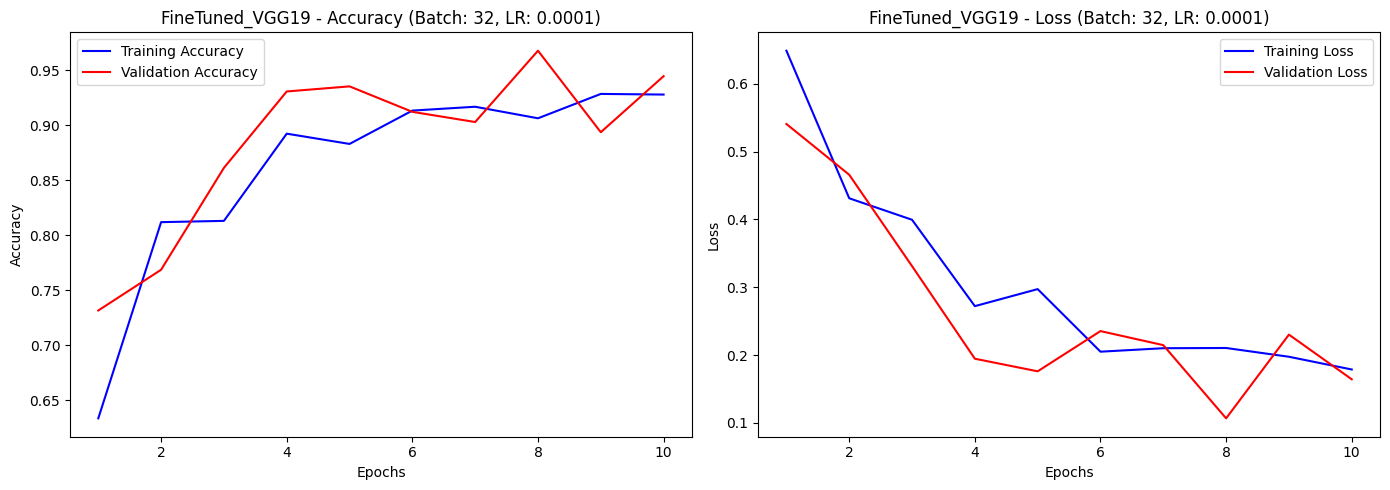

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Model: FineTuned_VGG19, Batch: 32, LR: 0.0001
Confusion Matrix:
[[118   6]
 [  3  89]]
Accuracy: 0.9583
Precision: 0.9368
Recall: 0.9674
F1 Score: 0.9519

Training FineTuned_VGG19 with batch size 32 and learning rate 1e-05
Found 1716 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 333ms/step - accuracy: 0.5626 - loss: 0.7094 - val_accuracy: 0.6528 - val_loss: 0.5591
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 301ms/step - accuracy: 0.6741 - loss: 0.6050 - val_accuracy: 0.7824 - val_loss: 0.4672
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 300ms/step - accuracy: 0.7801 - loss: 0.4638 - val_accuracy: 0.7917 - val_loss: 0.4533
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 303ms/step - accuracy: 0.8033 - loss: 0.4212 - val_accuracy: 0.8194 - val_loss: 0.4001
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 300ms/step - accuracy: 0.8217 - loss: 0.3870 - val_accuracy: 0.8241 - val_loss: 0.4094
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 298ms/step - accuracy: 0.8575 - loss: 0.3301 - val_accuracy: 0.8102 - val_loss: 0.3716
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 306ms/step - accuracy: 0.8541 - loss: 0.3287 - val_accuracy: 0.8611 - val_loss: 0.3141
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 300ms/step - accuracy: 0.9181 - loss: 0.2393 - val_accuracy: 0.944

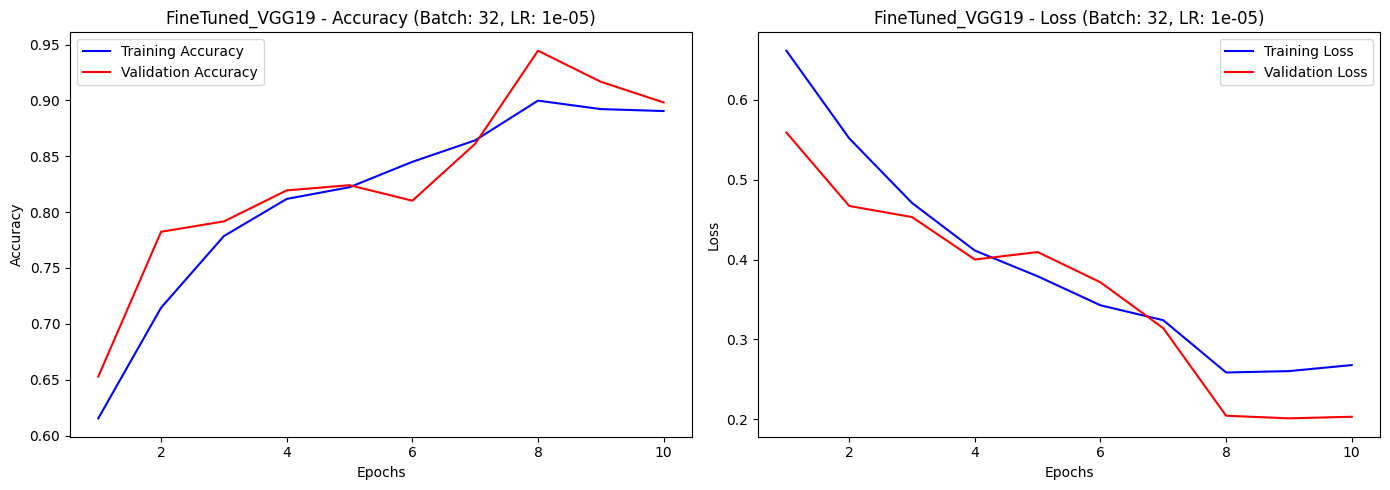

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Model: FineTuned_VGG19, Batch: 32, LR: 1e-05
Confusion Matrix:
[[122   2]
 [  9  83]]
Accuracy: 0.9491
Precision: 0.9765
Recall: 0.9022
F1 Score: 0.9379


In [19]:

for config in model_configs:
    for batch_size in batch_sizes:
        for lr in learning_rates:
            print(f"\nTraining {config['name']} with batch size {batch_size} and learning rate {lr}")
            
            train_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size=(img_width, img_height),
                batch_size=batch_size,
                class_mode='binary',
                subset='training'
            )

            validation_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size=(img_width, img_height),
                batch_size=batch_size,
                class_mode='binary',
                subset='validation'
            )
            
            # Create the model
            if 'fine_tune' in config:
                model = config['create_model'](fine_tune=config['fine_tune'])
            else:
                model = config['create_model']()

            # Compile the model
            model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss='binary_crossentropy',
                metrics=['accuracy']
            )

            # Train the model
            history = model.fit(
                train_generator,
                epochs=epochs,
                validation_data=validation_generator,
                verbose=1
            )

            # Plot training history
            plot_training_history(history, config['name'], batch_size, lr)

            # Evaluate the model and save metrics to CSV
            evaluate_and_save(config['name'], batch_size, lr, model, test_generator, 'model_metrics.csv')
